In [ ]:
import pandas as pd
import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import os
import time
import sklearn
from sklearn.decomposition import PCA
from multiprocessing import Pool, TimeoutError, Manager
from functools import partial
from rdkit.Chem import rdmolops
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SaltRemover
import pubchempy as pcp
import random
import json
import numpy as np
from tqdm import tqdm
from rdkit.Chem import PandasTools
from rdkit.Chem import rdmolops
from rdkit import RDConfig
import pickle 
from IPython.display import clear_output
clear_output()

In [ ]:
def load_predictions(target: str) -> pd.DataFrame():
    
    print("Loading Prediction Set")
    file_path=f"/home/paperspace/Desktop/DL_Project/final_outputs/{target}_predictions_flagged_admet_14Jan2024.xlsx"
    df=pd.read_excel(file_path)

    return df

In [ ]:
def load_and_format_prediction_set(target: str, drugbank_only=True) -> pd.DataFrame:

    predictions_df=load_predictions(target)

    # will actually remove chembl
    if drugbank_only:
        predictions_df=predictions_df[predictions_df['source']=='Drugbank'].reset_index(drop=True)
    print(f"Number of {target} predictions: {len(predictions_df):,}")
    print(f"Breakdown of predictions:")
    # predictions_df['binary_pred'].replace({0: 'Inactive', 1: 'Active'}, inplace=True)
    # predictions_df.rename(columns={"binary_pred": "prediction"}, inplace=True)
    # display(pd.DataFrame(predictions_df['prediction'].value_counts()))

    return predictions_df

In [7]:
app_first=pd.read_excel("../final_outputs/app_binary_property_flags_11Feb2024.xlsx")
app_bbb=pd.read_excel("../final_outputs/app_predictions_flagged_admet_11Feb2024.xlsx")
app_bbb=app_bbb.drop_duplicates(subset='uncharged_smiles')
app_active=app_first[app_first['prediction']=='Active']
app_full=app_active.merge(app_bbb[['uncharged_smiles', 'BBB']], how='left', on='uncharged_smiles')
app_full

,inchikey,uncharged_smiles,prediction,active_probability,database_id_x,database_id_y,smiles,drug_groups,molecular_weight,generic_name,...,mw_flag,cx_basic_flag,cx_acidic_flag,logd_flag,logp_flag,hbd_flag,hba_flag,rotation_flag,total_flags,BBB
0,HNDVDQJCIGZPNO-YFKPBYRVSA-N,N[C@@H](Cc1cnc[nH]1)C(=O)O,Active,0.934787,DB00117,DB00117,N[C@@H](Cc1cnc[nH]1)C(=O)O,investigational; nutraceutical,155.1546,Histidine,...,0,0,1,1,1,0,0,0,4,0.860
1,YBJHBAHKTGYVGT-ZKWXMUAHSA-N,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,Active,0.699660,DB00121,DB00121,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,approved; investigational; nutraceutical,244.3110,Biotin,...,0,0,1,1,1,0,0,1,4,0.949
2,XUWPJKDMEZSVTP-UOSCCXBLSA-N,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,Active,0.901323,DB01668,DB01668,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,experimental,300.2629,Nanaomycin D,...,0,0,0,1,1,0,0,0,3,0.007
3,KBPHJBAIARWVSC-RGZFRNHPSA-N,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,Active,0.218259,DB00137,DB00137,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,approved; investigational; nutraceutical,568.8860,Lutein,...,0,0,0,1,1,0,0,1,3,0.000
4,WBGKWQHBNHJJPZ-LECWWXJVSA-N,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,Active,0.422031,DB01260,DB01260,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,approved; investigational,416.5073,Desonide,...,0,0,0,0,0,0,0,0,1,0.939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,HZNVUJQVZSTENZ-UHFFFAOYSA-N,N#CC1=C(C#N)C(=O)C(Cl)=C(Cl)C1=O,Active,0.994486,DB15684,DB15684,N#CC1=C(C#N)C(=O)C(Cl)=C(Cl)C1=O,experimental,227.0000,"2,3-dichloro-5,6-dicyanobenzoquinone",...,0,0,0,0,1,0,0,0,2,0.193
510,XZBJVIQXJHGUBE-HZMVJJPJSA-N,C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@...,Active,0.889560,DB15777,DB15777,C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@...,experimental,460.5860,Fluocortolone pivalate,...,0,0,0,1,0,0,0,1,3,0.969
511,XMBWDFGMSWQBCA-UHFFFAOYSA-N,I,Active,0.999925,DB15778,DB15778,I,experimental,127.9120,Hydrogen iodide,...,0,0,1,0,1,0,0,0,2,NaN
512,BZRYYBWNOUALTQ-HOTGVXAUSA-N,CCN(CC)CCOCCC1=CC[C@H]2C[C@@H]1C2(C)C,Active,0.949482,DB15785,DB15785,CCN(CC)CCOCCC1=CC[C@H]2C[C@@H]1C2(C)C,experimental,265.4410,Myrtecaine,...,0,0,0,1,0,0,0,1,2,0.265


In [ ]:
app_full['uncharged_inchikey'].duplicated().sum()

In [ ]:
app_full['uncharged_smiles'].duplicated().sum()

In [ ]:
app_full.drop_duplicates(subset='uncharged_inchikey')

In [ ]:
### not ton of correlation between 
# plt.scatter(app_full['total_flags'], app_full['BBB'])

In [9]:
tau_first=pd.read_excel("../final_outputs/tau_binary_property_flags_11Feb2024.xlsx")
tau_bbb=pd.read_excel("../final_outputs/tau_predictions_flagged_admet_11Feb2024.xlsx")
tau_bbb=tau_bbb.drop_duplicates(subset='uncharged_smiles')
tau_active=tau_first[tau_first['prediction']=='Active']
tau_full=tau_active.merge(tau_bbb[['uncharged_smiles', 'BBB']], how='left', on='uncharged_smiles')
# tau_full.drop_duplicates(sub)

In [ ]:
tau_full.columns

In [10]:
# tau_bbb[tau_bbb['uncharged_smiles']=='C[C@@H](O)CO']
flag_cols=[col for col in tau_full.columns if "flag" in col]

tau_full.columns
tau_full=tau_full[['inchikey', 'uncharged_smiles', 'drug_groups', 'prediction', 'active_probability',
'database_id_x', 'BBB']+flag_cols]

In [11]:
app_full=app_full[['inchikey', 'uncharged_smiles', 'drug_groups', 'prediction', 'active_probability',
'database_id_x', 'BBB']+flag_cols]

In [ ]:
app_full

In [12]:
metadata_cols=['uncharged_smiles', 'database_id_x', 'BBB', 'drug_groups']+flag_cols
metadata_cols

['uncharged_smiles',
 'database_id_x',
 'BBB',
 'drug_groups',
 'psa_flag',
 'mw_flag',
 'cx_basic_flag',
 'cx_acidic_flag',
 'logd_flag',
 'logp_flag',
 'hbd_flag',
 'hba_flag',
 'rotation_flag',
 'total_flags']

In [13]:
tau_metadata=tau_full[metadata_cols]
app_metadata=app_full[metadata_cols]

all_metadata=pd.concat([tau_metadata, app_metadata]).drop_duplicates()
all_metadata
# tau_metadata

,uncharged_smiles,database_id_x,BBB,drug_groups,psa_flag,mw_flag,cx_basic_flag,cx_acidic_flag,logd_flag,logp_flag,hbd_flag,hba_flag,rotation_flag,total_flags
0,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,DB01661,0.469,experimental,1,0,0,0,1,1,1,1,1,6
1,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,DB01668,0.007,experimental,1,0,0,0,1,1,0,0,0,3
2,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,DB00137,0.000,approved; investigational; nutraceutical,0,0,0,0,1,1,0,0,1,3
3,CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3,DB00714,0.987,approved; investigational,0,0,0,0,0,0,0,0,0,0
4,[H]/N=C(\N)c1ccc2cc(C(=O)Nc3ccc(CN)cc3)ccc2c1,DB02398,0.191,experimental,1,0,1,0,1,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O,DB15653,0.408,investigational,1,0,1,0,1,1,0,1,0,5
510,C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@...,DB15777,0.969,experimental,1,0,0,0,1,0,0,0,1,3
511,I,DB15778,NaN,experimental,0,0,0,1,0,1,0,0,0,2
512,CCN(CC)CCOCCC1=CC[C@H]2C[C@@H]1C2(C)C,DB15785,0.265,experimental,0,0,0,0,1,0,0,0,1,2


### Determine Nominations Overlap Between Targets

In [14]:
# app_targets=pd.read_excel("/home/paperspace/Desktop/DL_Project/ipynb_files/app_detailed_nominations.xlsx")
app_preds=app_full[['uncharged_smiles', 'prediction', 'active_probability']]
app_preds.rename(columns={'prediction': 'app_prediction',
                            'active_probability': 'app_probability'}, inplace=True)
app_preds
# app_metadata=app_targets.drop(columns=['prediction', 'active_probability'])

/tmp/ipykernel_3115/1295486724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_preds.rename(columns={'prediction': 'app_prediction',


,uncharged_smiles,app_prediction,app_probability
0,N[C@@H](Cc1cnc[nH]1)C(=O)O,Active,0.934787
1,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,Active,0.699660
2,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,Active,0.901323
3,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,Active,0.218259
4,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,Active,0.422031
...,...,...,...
509,N#CC1=C(C#N)C(=O)C(Cl)=C(Cl)C1=O,Active,0.994486
510,C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@...,Active,0.889560
511,I,Active,0.999925
512,CCN(CC)CCOCCC1=CC[C@H]2C[C@@H]1C2(C)C,Active,0.949482


In [15]:
# tau_targets=pd.read_excel("/home/paperspace/Desktop/DL_Project/ipynb_files/tau_detailed_nominations.xlsx")

tau_preds=tau_full[['uncharged_smiles', 'prediction', 'active_probability']]
tau_preds.rename(columns={'prediction': 'tau_prediction',
                            'active_probability': 'tau_probability'}, inplace=True)
tau_preds
# tau_metadata=tau_targets.drop(columns=['prediction', 'active_probability'])

/tmp/ipykernel_3115/1891817817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tau_preds.rename(columns={'prediction': 'tau_prediction',


,uncharged_smiles,tau_prediction,tau_probability
0,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,Active,0.296084
1,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,Active,0.994655
2,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,Active,0.954262
3,CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3,Active,0.999998
4,[H]/N=C(\N)c1ccc2cc(C(=O)Nc3ccc(CN)cc3)ccc2c1,Active,0.991272
...,...,...,...
531,O=C(NC(=O)c1c(F)cccc1F)Nc1ccc(Cl)c(Oc2ncc(C(F)...,Active,0.919382
532,COc1cc(-c2cc(=O)c3c(O)cc(O)c(CC=C(C)C)c3o2)ccc1O,Active,0.999504
533,C[C@@H]1CC(=O)c2c(ccc3c2C(=O)c2cccc(O)c2C3=O)C1,Active,0.947559
534,O=C1c2c(O)cc(O)cc2O[C@H](c2cc(O)c(O)c(O)c2)[C@...,Active,0.756694


In [16]:
combined_preds=tau_preds.merge(app_preds, how='outer', on='uncharged_smiles')
combined_preds['active_both']=(combined_preds['tau_prediction']=='Active') & (combined_preds['app_prediction']=='Active')

In [17]:
combined_preds['tau_prediction']=combined_preds['tau_prediction'].fillna("Inactive")
combined_preds['app_prediction']=combined_preds['app_prediction'].fillna("Inactive")

In [18]:
all_preds_data=combined_preds.merge(all_metadata, how='left', on='uncharged_smiles')
all_preds_data.reset_index(drop=True, inplace=True)
all_preds_data=all_preds_data[~all_preds_data['BBB'].isnull()]
all_preds_data.drop_duplicates(subset='uncharged_smiles', inplace=True)

In [19]:
pd.DataFrame(all_preds_data['drug_groups'].value_counts())

,drug_groups
experimental,500
investigational,234
approved; investigational,58
approved,53
approved; experimental,14
experimental; investigational,11
experimental; illicit,8
vet_approved,7
approved; vet_approved,5
approved; withdrawn,4


In [55]:
targets=['app', 'tau']


for target in targets:

    active=all_preds_data[all_preds_data[f'{target}_prediction']=='Active']
    counts=active.groupby([f'{target}_prediction'])['drug_groups'].value_counts()
    counts=pd.DataFrame(counts).rename(columns={'drug_groups': 'count'})

    
    counts=counts.reset_index()
    counts['drug_groups']=counts['drug_groups'].str.replace("vet_approved", "vet yes")
    approved=counts[(counts['drug_groups'].str.contains("approved")) & (~counts['drug_groups'].str.contains("withdrawn"))]['count'].sum()
    print(f"{target}: num approved {approved}")
    # display(counts)
# all_preds_data.groupby(['app_prediction'])['drug_groups'].value_counts()

app: num approved 85
tau: num approved 68


In [61]:
# all_preds_data['drug_groups']=all_preds_data[''] 

In [57]:
all_preds_data.to_excel("active_preds_all_metadata_for_finalization_11Feb2024.xlsx", index=False)

## Preds Formatted - For Final Evaluation

In [58]:
all_preds_data=pd.read_excel("active_preds_all_metadata_for_finalization_11Feb2024.xlsx")

In [60]:
# all_preds_data.columns
all_preds_data[all_preds_data['drug_groups'].str.contains("vet")]

,uncharged_smiles,tau_prediction,tau_probability,app_prediction,app_probability,active_both,database_id_x,BBB,drug_groups,psa_flag,mw_flag,cx_basic_flag,cx_acidic_flag,logd_flag,logp_flag,hbd_flag,hba_flag,rotation_flag,total_flags
10,CN1C=CC=C/C1=C\N=O,Active,0.999379,Active,0.652401,True,DB00733,0.454,approved; vet_approved,0,0,0,0,1,1,0,0,0,2
112,C=O,Active,0.999996,Active,1.000000,True,DB03843,0.304,approved; vet_approved,0,0,0,0,1,1,0,0,0,2
148,O=C(O)CC(O)(CC(=O)O)C(=O)O,Active,0.674244,Inactive,NaN,False,DB04272,0.067,approved; nutraceutical; vet_approved,1,0,0,1,1,1,0,0,1,5
347,CCN(CC)c1ccc(C(=C2C=CC(=[N+](CC)CC)C=C2)c2cccc...,Active,0.604292,Inactive,NaN,False,DB11279,0.009,approved; vet_approved,0,0,1,0,0,0,0,0,1,2
357,CN(Cc1ccccc1)C(=O)[C@@H](NC(=O)c1cc2cc(NC(=O)c...,Active,0.972146,Inactive,NaN,False,DB11399,0.037,investigational; vet_approved,1,1,0,0,1,1,0,0,1,5
361,O=C(NC(=O)c1c(F)cccc1F)Nc1cc(Cl)c(OC(F)(F)[C@@...,Active,0.899334,Inactive,NaN,False,DB11424,0.027,experimental; vet_approved,0,0,0,0,1,1,0,1,1,4
364,CCCCc1cc2c(=O)c(C(=O)OC)c[nH]c2cc1OCc1ccccc1,Active,0.241529,Inactive,NaN,False,DB11433,0.119,vet_approved,0,0,0,0,1,1,0,0,1,3
375,[H]/N=C(/c1ccc(OCCCCCC)c2ccccc12)N(CCCC)CCCC,Active,0.966986,Inactive,NaN,False,DB11501,0.421,vet_approved,0,0,0,0,1,1,0,0,1,3
378,CCN1C(=CC=CC=Cc2sc3ccccc3[n+]2CC)Sc2ccccc21,Active,0.560892,Active,0.999402,True,DB11516,0.205,vet_approved; withdrawn,0,0,0,0,0,0,0,0,1,1
382,O=C(Nc1cccc(C2=NCCN2)c1)Nc1cccc(C2=NCCN2)c1,Active,0.940460,Inactive,NaN,False,DB11521,0.237,vet_approved,1,0,0,0,1,0,0,0,0,2


In [39]:
all_preds_data['tau_prediction'].value_counts()

Active      505
Inactive    406
Name: tau_prediction, dtype: int64

In [40]:
all_preds_data['app_prediction'].value_counts()

Active      494
Inactive    417
Name: app_prediction, dtype: int64

In [41]:
def filter_actives(df: pd.DataFrame, 
                    target: str, 
                    flag_threshold=3, 
                    bbb_threshold=0.9,
                    percentile=0.9,
                    fda_filter=False) -> pd.DataFrame:

    filtered=df.copy()
    filtered=filtered[filtered[f"{target}_probability"] > percentile]
    filtered=filtered[filtered['total_flags']<=flag_threshold]
    filtered=filtered[filtered['BBB']>=bbb_threshold]
    
    if fda_filter:
        filtered['drug_groups']=filtered['drug_groups'].str.replace("vet_approved", "vet_appro")
        filtered=filtered[(filtered['drug_groups'].str.contains("approved")) &\
                            (~filtered['drug_groups'].str.contains("withdrawn"))]

    filtered=filtered.sort_values(by=[f"{target}_probability", 'total_flags'], ascending=False)
    filtered.reset_index(drop=True, inplace=True)
    
    return filtered

### Filter Down Predictions on Different Parameters

In [89]:
tau_filtered=filter_actives(all_preds_data, target='tau', bbb_threshold=0,
                            flag_threshold=9, percentile=0.2, fda_filter=False)
app_filtered=filter_actives(all_preds_data, target='app', bbb_threshold=0,
                            flag_threshold=9, percentile=0.2, fda_filter=False)

In [90]:
tau_filtered[['uncharged_smiles', 'database_id_x', 'drug_groups', 'total_flags', 'tau_probability']]

,uncharged_smiles,database_id_x,drug_groups,total_flags,tau_probability
0,Cc1cc(O)c2c(=O)c3c(O)cc(O)c4c5c(O)cc(O)c6c(=O)...,DB13014,investigational,5,1.000000
1,C[C@H](O)c1cc(C(=O)O)nc2c1C=CC[C@@H]2O,DB02566,experimental,3,1.000000
2,O=c1[nH]sc2cc(Cl)ccc12,DB13613,experimental,0,1.000000
3,Nc1cc(C[C@H](N)C(=O)O)c(O)cc1O,DB02928,experimental,3,1.000000
4,O=C(O)CCC(=O)C1=CC=C[C@@H](O)[C@@H]1C(=O)O,DB06864,experimental,4,1.000000
...,...,...,...,...,...
500,NC[C@H](O)CNc1ccc([N+](=O)[O-])c2cccnc12,DB07037,experimental,3,0.204176
501,COC(=O)c1c(C)cc(Oc2cc(C)cc(O)c2O)cc1O,DB08179,experimental,2,0.204138
502,[H]/N=C(\N)c1ccc(CNC(=O)[C@@H]2CCCN2C(=O)CCC2C...,DB07095,experimental,4,0.203757
503,c1ccc(-p2c(-c3ccccn3)c3c(c2-c2ccccn2)CCCC3)cc1,DB07393,experimental,1,0.200821


In [98]:
tau_filtered['total_flags'].value_counts().sort_index()

0     38
1     71
2    120
3    103
4    112
5     46
6     12
7      3
Name: total_flags, dtype: int64

In [101]:
505-(112+47+12+3)

331

<AxesSubplot:>

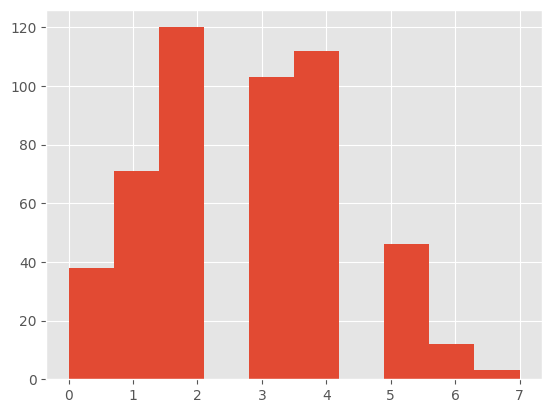

In [97]:
tau_filtered['total_flags'].hist()

In [81]:
app_filtered[['uncharged_smiles', 'database_id_x', 'drug_groups', 'total_flags']]

,uncharged_smiles,database_id_x,drug_groups,total_flags
0,[C-]#[O+],DB11588,approved; investigational,2
1,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,DB00180,approved; investigational,1
2,S=C(SSC(=S)N1CCCCC1)N1CCCCC1,DB14174,approved; experimental,1
3,CCc1c(C)[nH]c2c1C(=O)[C@@H](CN1CCOCC1)CC2,DB01618,approved,1
4,c1ccc2c(c1)CCc1ccccc1N2[C@H]1CN2CCC1CC2,DB13246,approved,1
5,CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3C[...,DB14657,approved,1
6,COC(=O)CC[C@@H]1N=C(c2ccccn2)c2cc(Br)ccc2-n2c(...,DB12404,approved; investigational,1
7,C[C@]12C=CC(=O)C=C1[C@@H](F)C[C@@H]1[C@@H]2[C@...,DB09378,approved,2
8,C[C@H]1C[C@@H]2[C@H](C(=O)C[C@@]3(C)[C@H]2CC[C...,DB12952,approved; investigational,2
9,C=C[C@H]1CN2CC[C@H]1C[C@H]2[C@H](O)c1ccnc2ccc(...,DB00468,approved,0


In [103]:
### Tau Finals
# drugbank_ids=["DB06202",
#             "DB01731",
#             "DB02277",
#            'DB00714']

drugbank_ids=['DB00714']

tau_filtered[tau_filtered['database_id_x'].isin(drugbank_ids)]

,uncharged_smiles,tau_prediction,tau_probability,app_prediction,app_probability,active_both,database_id_x,BBB,drug_groups,psa_flag,mw_flag,cx_basic_flag,cx_acidic_flag,logd_flag,logp_flag,hbd_flag,hba_flag,rotation_flag,total_flags
12,CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3,Active,0.999998,Inactive,NaN,False,DB00714,0.987,approved; investigational,0,0,0,0,0,0,0,0,0,0


In [77]:
### APP Finals

drugbank_ids=["DB00180",
            "DB01618",
            "DB13246",
            'DB09378']

app_filtered[app_filtered['database_id_x'].isin(drugbank_ids)]

,uncharged_smiles,tau_prediction,tau_probability,app_prediction,app_probability,active_both,database_id_x,BBB,drug_groups,psa_flag,mw_flag,cx_basic_flag,cx_acidic_flag,logd_flag,logp_flag,hbd_flag,hba_flag,rotation_flag,total_flags
12,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,Inactive,NaN,Active,0.983538,False,DB00180,0.950,approved; investigational,1,0,0,0,0,0,0,0,0,1
21,CCc1c(C)[nH]c2c1C(=O)[C@@H](CN1CCOCC1)CC2,Inactive,NaN,Active,0.955413,False,DB01618,0.977,approved,0,0,0,0,1,0,0,0,0,1
23,c1ccc2c(c1)CCc1ccccc1N2[C@H]1CN2CCC1CC2,Inactive,NaN,Active,0.943694,False,DB13246,0.996,approved,0,0,0,0,1,0,0,0,0,1
30,C[C@]12C=CC(=O)C=C1[C@@H](F)C[C@@H]1[C@@H]2[C@...,Inactive,NaN,Active,0.904614,False,DB09378,0.880,approved,1,0,0,0,0,1,0,0,0,2


In [ ]:
all_nom_ids=["DB00180",
            "DB01618",
            "DB13246",
            "DB14174", #
            "DB06202",
            "DB01731",
            "DB02277",
            "DB02473"] # 

all_nom_ids=["DB00714",
"DB09378"
]
noms_smiles=[]

for drugbank_id in all_nom_ids:
    noms_smiles.append(all_preds_data[all_preds_data['database_id_x']==drugbank_id]['uncharged_smiles'].item())
    print(all_preds_data[all_preds_data['database_id_x']==drugbank_id]['uncharged_smiles'].item())

In [ ]:
noms_smiles

In [ ]:
from PIL import Image
from io import BytesIO
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)
def show_images(imgs,buffer=5):
    height = 0
    width = 0
    for img in imgs:
        height = max(height,img.height)
        width += img.width
    width += buffer*(len(imgs)-1)
    res = Image.new("RGBA",(width,height))
    x = 0
    for img in imgs:
        res.paste(img,(x,0))
        x += img.width + buffer
    return res

In [ ]:
from rdkit.Chem import rdDepictor
from rdkit.Chem import Draw
# def visualize(smiles: str) -> None:
#     print(smiles)
#     return display(Chem.MolFromSmiles(smiles))

imgs=[]
for smiles in noms_smiles:
    d2d = Draw.MolDraw2DCairo(350,300)
    dopts = d2d.drawOptions()
    # dopts.setBackgroundColour((0.85, 0.85, 0.85))
    mol=Chem.MolFromSmiles(smiles)
    imgs.append(show_mol(d2d,mol))
    
for db_id, img in zip(all_nom_ids, imgs):

    img.save(f"{db_id}.png")

In [ ]:
all_preds_data['passes_flags']=np.where(all_preds_data['total_flags']<=4,
                                        "Yes", "No")

all_preds_data['passes_bbb']=np.where(all_preds_data['BBB']>=0.8,
                                        "Yes", "No")  

all_preds_data['passes_both']=np.where((all_preds_data['passes_flags']=='Yes') & (all_preds_data['passes_bbb']=='Yes'), "Yes", "No")            
all_preds_data['fails_both']=np.where((all_preds_data['passes_flags']=='No') & (all_preds_data['passes_bbb']=='No'), "Yes", "No")                                  

In [ ]:
cols=['fails_both', 'passes_flags', 'passes_bbb', 'passes_both']

tau=all_preds_data[all_preds_data['tau_prediction']=='Active']
app=all_preds_data[all_preds_data['app_prediction']=='Active']

print(f"Length of tau: {len(tau)}")
print(f"Length of APP: {len(app)}")

for col in cols:

    print("APP")
    display(pd.DataFrame(app[col].value_counts()))
    print("Tau")
    display(pd.DataFrame(tau[col].value_counts()))
    print("-------------")
    print("-------------")

In [ ]:
all_preds_data['passes_flags'].value_counts()

In [ ]:
all_preds_data['passes_bbb'].value_counts()

In [ ]:
all_preds_data['passes_both'].value_counts()

In [ ]:
all_preds_data['fails_both'].value_counts()

In [ ]:
all_preds_data

In [ ]:
for_plot=all_preds_data.copy()
# for_plot['total_flags'

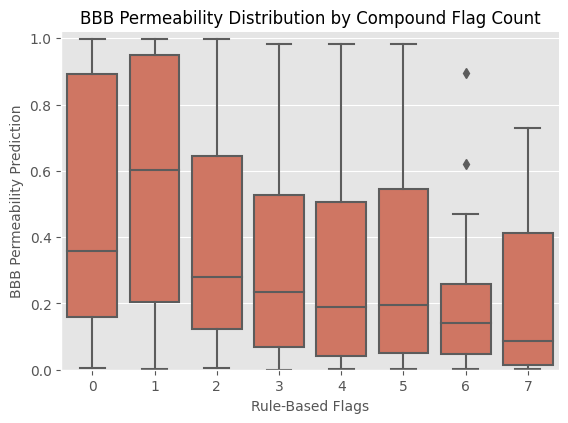

In [88]:
import seaborn as sns

# sns.set(rc={'figure.figsize':(11.7,15.27)})
# from matplotlib import rcParams

# figure size in inches
# rcParams['figure.figsize'] = 11.7,8.27
g=sns.catplot(data=all_preds_data, x="total_flags", y="BBB", kind="box", color= '#E16B51')
plt.title("BBB Permeability Distribution by Compound Flag Count", size=12)
plt.ylabel("BBB Permeability Prediction", size=10)
plt.xlabel("Rule-Based Flags", size=10)
g.set_xticklabels(size = 10)
g.set_yticklabels(size = 10)
plt.ylim([0, 1.02])

g.fig.set_size_inches(6,4)

plt.savefig("BBB_by_compound_flag_relationship.png", dpi=400, bbox_inches="tight")
plt.show()

In [ ]:
dir(g)

In [ ]:
# tau_filtered['drug_groups'].value_counts()
app_filtered

In [ ]:
## pick 2 that are FDA approved
## two experimental or investigative

In [ ]:
## ABX-464 interesting
## Ticlatone interesting
## Triclocarban is bad - banned hormone stuff
## Anethole trithione interesting
## Clofazimine is a highly lipophilic antimicrobial riminophenazine dye used 
# in combination with other agents, such as [dapsone], for the treatment of leprosy.
# Apomorphine is an aporphine alkaloid. It has a role as an alpha-adrenergic drug, a 
# serotonergic drug, an antidyskinesia agent, a dopamine agonist, an antiparkinson drug 
# and an emetic. It derives from a hydride of an aporphine.
# Progabide is an analog and prodrug of gamma-aminobutyric acid. It is commonly used in
#  the treatment of epilepsy. It has agonistic activity for both the GABAA and GABAB receptors. 
# In clinical trials, progabide has been investigated for Parkinson's disease, schizophrenia, 
# clinical depression and anxiety disorder; its therapeutic effectiveness in these conditions
#  is not fully elucidated.

### Where do Drugs in general reside in chemical space?

### merge full preds to drugbank on database_id. Then can have all metadata but not remove the other compounds thatgot removed somewhere alongt he line.

In [ ]:
all_preds=pd.read_excel("app_tau_predictions_combined_active_inactive.xlsx")
drugbank=load_drugbank()

In [ ]:
drugbank['canonical_smiles'], drugbank['cleaned_smiles'], drugbank['cleaned_charge'] = zip(*drugbank['smiles'].apply(lambda x: strip_salts_neutralize(x)))

In [ ]:
drugbank['smiles_equal']=drugbank['canonical_smiles']==drugbank['cleaned_smiles']
display(pd.DataFrame(drugbank['smiles_equal'].value_counts()))

### Generate Morgan FPs on Drugbank Cleaned SMILES

In [ ]:
# generate morgan fingerprint 2048 length vector - multiprocessing

def generate_morgan_fp(lst, compound_data):

    # compound_data = list -> index 0 = inchi, index 1 = isomeric smile
    mol = Chem.MolFromSmiles(compound_data[1])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits = 2048)
    compound_data.append(fp.ToBitString()) # [inchi, iso_smile, fp]
    lst.append(compound_data) # list of lists
    pbar.update(1)


fp_function_columns = drugbank[['inchikey', 'cleaned_smiles']].values.tolist()

print("First two elements of list:")
fp_function_columns[:2]

In [ ]:
# parallelize generation
if __name__ == '__main__':

    pbar = tqdm(total=len(drugbank)/8)
    dfs_list = Manager().list()
    pool = Pool(processes=8)
    res = pool.map_async(partial(generate_morgan_fp, dfs_list), fp_function_columns)
    res.wait()
    pbar.close()

In [ ]:
fp_df = pd.DataFrame(list(dfs_list), columns=['inchikey', 'cleaned_smiles', 'morgan_fp'])  # the final result

drugbank_fps=drugbank.merge(fp_df, how='left', on=['inchikey', 'cleaned_smiles'])
drugbank_fps.head(2)

In [ ]:
## 5 minutes
def generate_int_fp(lst, data):

    lst.append(list(map(int, data)))

morgan_df_vals = drugbank_fps['morgan_fp'].values.tolist()

if __name__ == '__main__':

    pbar = tqdm(total=len(drugbank)/8)
    dfs_list = Manager().list()
    pool = Pool(processes=8)
    res = pool.map_async(partial(generate_int_fp, dfs_list), morgan_df_vals)
    res.wait()
    pbar.close()
    fp_df = pd.DataFrame(list(dfs_list))

# fp_df.head()

In [ ]:

with open('pca_model_2023Ded22.pkl', 'rb') as f:
    pretrained_pca = pickle.load(f)

In [ ]:
### reduce the fps to 3 dimensions
reduced_fps=pretrained_pca.transform(fp_df)

In [ ]:
drugbank_fps['first_component_pca'] = [i[0] for i in reduced_fps]
drugbank_fps['second_component_pca'] = [i[1] for i in reduced_fps]
drugbank_fps['third_component_pca'] = [i[2] for i in reduced_fps]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
drugbank_fps['safety_concern']="No"
drugbank_fps['safety_concern']=np.where((drugbank_fps['drug_groups'].str.contains("illic")) | (drugbank_fps['drug_groups'].str.contains("withdr")),
                            "Yes",
                            "No")

In [ ]:
drugbank_fps['safety_concern'].value_counts()

In [ ]:
import seaborn as sns
sns.scatterplot(data=drugbank_fps, x='first_component_pca', y='second_component_pca', hue='safety_concern')
sns.scatterplot(data=drugbank_fps[drugbank_fps['safety_concern']=="Yes"], x='first_component_pca', y='second_component_pca')
plt.legend(title='Withdrawn or Illicit')
plt.title("Drugbank Compounds Prediction Set")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.show()

### Check Which Drugs Are CNS Drugs, were they nominated? were they filtered by my criteria?

In [ ]:
drugbank_fps

### How Many Different Scaffolds Did Drugbank Make up? Any patterns in scaffolds it likes?